# Zillow Zestimate Features That Drive Error


## Project Planning

### Goals

To determine the features that drive Zillow's Zestimate error. 

### Deliverables

What should the zillow team expect to receive from you?  Again, as you were communicating to them, not to your instructors.  

*your deliverables:*
1. *A report (in the form of a presentation, both verbal and through a slides) that summarizes your findings about the drivers of the Zestimate error. This will come from the analysis you do during the exploration phase of the pipeline. In the report, you will have charts that visually tell the story of what is driving the errors.*

2. *A Jupyter notebook, titled 'Regression_Proj_YourName', that contains a clearly labeled section and code clearly documented for each the stages below (project planning, data acquisition, data prep, exploration, and modeling). All of the work will take place in your jupyter notebook.*

### Data Dictionary & Details

- logerror- The log function of the difference of the sales price and the Zestimate.
- bathroomcnt- Number of bathrooms in home including fractional bathrooms
- bedroomcnt- Number of bedrooms in home
- calculatedfinishedsquarefeet- Calculated total finished living area of the home
- fullbathcnt- Number of full bathrooms (sink, shower + bathtub, and toilet) present in home
- garagecarcnt- Total number of garages on the lot including an attached garage
- roomcnt- Total number of rooms in the principal residence
- yearbuilt- The Year the principal residence was built
- taxvaluedollarcnt- The total tax assessed value of the parcel
- taxamount- The total property tax assessed for that assessment year
- rmcount- The sum of bathroom count and bedroom count
- value_per_sq_ft- tax value dollar count divided by calculated finished square feet
- age_of_property- Age in years of property since it was built
- abs_logerror- Absolute value of log error

### Initial Thoughts, Ideas, Hypotheses

- There are some variables that are redundant and can be dropped: fullbathcnt, one of the tax variables
- Some variables have so much information missing that they can be dropped: garagecnt
- room count does not seem accurate... might make a new one
- square feet and tax value dollar count might have the biggest impact on error
- Plan on filling the nulls with zeros and dropping rows where zero does not make sense
- Would be interesting to make columns for age in years of property and tax value per sq ft
- Would taking absolute value of log error make visualization better?

### Prepare your environment

import libraries you will use throughout the project.  You may need to add to this as you go.  But try to keep all of your imports in this section

In [71]:
import pandas as pd

import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

import statsmodels.api as sm

from scipy.stats import pearsonr, ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

### Data Acquisition

#### Acquire via csv

- add the path to where your files are located in your env.py file. 
- ensure that others can read the files based on their local env.py file. 

recommendations for dealing with the large dataset
- remove any without a logerror
- sample until you have the right query (and then pull entire dataset)
- export to local csv 
- read from local csv (sample, but larger sample than your first) 
- save sql query to add into to_sql() function in python. 

In [72]:
path = './'
df_prop = pd.read_csv(path + "properties_2016.csv")
df_log = pd.read_csv(path + "train_2016_v2.csv")

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [73]:
df_merge = df_prop.merge(df_log, on='parcelid',how='inner')
df_merge.duplicated().sum()

0

In [74]:
df = df_merge[['parcelid', 'logerror', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'garagecarcnt', 'roomcnt', 'yearbuilt', 'taxvaluedollarcnt', 'taxamount']]
df.shape

(90275, 11)

### Data Preparation

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 11 columns):
parcelid                        90275 non-null int64
logerror                        90275 non-null float64
bathroomcnt                     90275 non-null float64
bedroomcnt                      90275 non-null float64
calculatedfinishedsquarefeet    89614 non-null float64
fullbathcnt                     89093 non-null float64
garagecarcnt                    29937 non-null float64
roomcnt                         90275 non-null float64
yearbuilt                       89519 non-null float64
taxvaluedollarcnt               90274 non-null float64
taxamount                       90269 non-null float64
dtypes: float64(10), int64(1)
memory usage: 8.3 MB


In [76]:
df2 = df.fillna(0)

In [77]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 11 columns):
parcelid                        90275 non-null int64
logerror                        90275 non-null float64
bathroomcnt                     90275 non-null float64
bedroomcnt                      90275 non-null float64
calculatedfinishedsquarefeet    90275 non-null float64
fullbathcnt                     90275 non-null float64
garagecarcnt                    90275 non-null float64
roomcnt                         90275 non-null float64
yearbuilt                       90275 non-null float64
taxvaluedollarcnt               90275 non-null float64
taxamount                       90275 non-null float64
dtypes: float64(10), int64(1)
memory usage: 8.3 MB


In [78]:
df2 = df.drop_duplicates(subset='parcelid', keep='first', inplace=False)
df2.shape

(90150, 11)

In [79]:
df2.dtypes

parcelid                          int64
logerror                        float64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
fullbathcnt                     float64
garagecarcnt                    float64
roomcnt                         float64
yearbuilt                       float64
taxvaluedollarcnt               float64
taxamount                       float64
dtype: object

In [80]:
df2

,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,garagecarcnt,roomcnt,yearbuilt,taxvaluedollarcnt,taxamount
0,17073783,0.0953,2.5,3.0,1264.0,2.0,2.0,5.0,1986.0,191811.0,2015.06
1,17088994,0.0198,1.0,2.0,777.0,1.0,1.0,4.0,1990.0,239679.0,2581.30
2,17100444,0.0060,2.0,3.0,1101.0,2.0,2.0,5.0,1956.0,47853.0,591.64
3,17102429,-0.0566,1.5,2.0,1554.0,1.0,2.0,5.0,1965.0,62914.0,682.78
4,17109604,0.0573,2.5,4.0,2415.0,2.0,2.0,8.0,1984.0,554000.0,5886.92
5,17125829,0.0564,2.5,4.0,2882.0,2.0,2.0,8.0,1980.0,289609.0,3110.44
6,17132911,0.0315,2.0,3.0,1772.0,2.0,2.0,6.0,1978.0,526000.0,5632.20
7,17134926,0.0257,2.5,5.0,2632.0,2.0,2.0,8.0,1971.0,571086.0,6109.94
8,17139988,0.0020,2.0,3.0,1292.0,2.0,2.0,6.0,1979.0,462594.0,5026.40
9,17167359,-0.0576,1.0,3.0,1385.0,1.0,1.0,6.0,1950.0,268502.0,3217.06


In [81]:
df2[df2.bathroomcnt == 0].count()

parcelid                        1159
logerror                        1159
bathroomcnt                     1159
bedroomcnt                      1159
calculatedfinishedsquarefeet     510
fullbathcnt                        0
garagecarcnt                     218
roomcnt                         1159
yearbuilt                        492
taxvaluedollarcnt               1159
taxamount                       1159
dtype: int64

In [82]:
df2 = df2.drop(df2[df2.bathroomcnt == 0].index)

In [83]:
df2.describe()

,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,garagecarcnt,roomcnt,yearbuilt,taxvaluedollarcnt,taxamount
count,8.899100e+04,88991.000000,88991.000000,88991.000000,88982.000000,88974.000000,29679.000000,88991.000000,88905.000000,8.899000e+04,88985.000000
mean,1.297212e+07,0.011450,2.309234,3.070603,1768.921523,2.241172,1.823276,1.495927,1968.591722,4.576632e+05,5973.263868
std,2.507768e+06,0.158423,0.976144,1.111178,924.388110,0.963106,0.592598,2.831608,23.766790,5.537837e+05,6807.681721
min,1.071174e+07,-4.605000,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000,1885.000000,2.200000e+01,49.080000
25%,1.155593e+07,-0.025300,2.000000,2.000000,1182.000000,2.000000,2.000000,0.000000,1953.000000,2.003985e+05,2881.190000
50%,1.254235e+07,0.006000,2.000000,3.000000,1538.000000,2.000000,2.000000,0.000000,1970.000000,3.435255e+05,4544.600000
75%,1.421961e+07,0.038300,3.000000,4.000000,2089.750000,3.000000,2.000000,0.000000,1987.000000,5.405890e+05,6892.940000
max,1.629608e+08,4.737000,20.000000,16.000000,22741.000000,20.000000,24.000000,18.000000,2015.000000,2.775000e+07,321936.090000


#### Create a variable, `colnames`, that is a list of the column names. 

In [84]:
colnames= ['parcelid', 'logerror', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'garagecarcnt', 'roomcnt', 'yearbuilt', 'taxvaluedollarcnt', 'taxamount']
colnames

['parcelid',
 'logerror',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'fullbathcnt',
 'garagecarcnt',
 'roomcnt',
 'yearbuilt',
 'taxvaluedollarcnt',
 'taxamount']

#### independent variable names (aka attributes) 

In [85]:
x_vars = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'garagecarcnt', 'roomcnt', 'yearbuilt', 'taxvaluedollarcnt', 'taxamount']


#### dependent (target) variable. 

dependent variable: 'logerror', continuous

#### View the distribution of the numeric variables

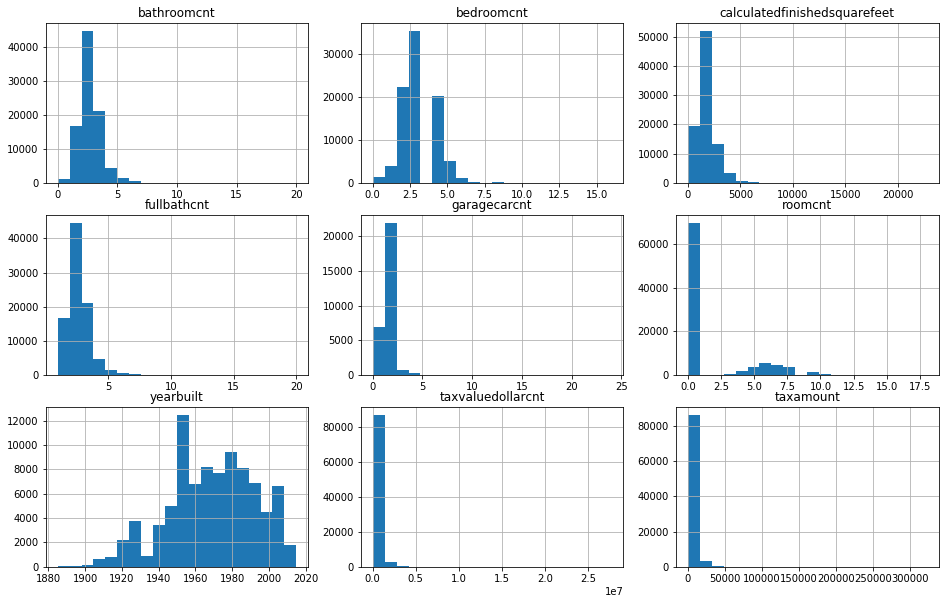

In [86]:
plt.figure(figsize=(16, 10))

for i, col in enumerate(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'garagecarcnt', 'roomcnt', 'yearbuilt', 'taxvaluedollarcnt', 'taxamount']):
    plot_number = i + 1 
    series = df[col]
    plt.subplot(3, 3, plot_number)
    plt.title(col)
    series.hist(bins=20, density=False, cumulative=False, log=False)

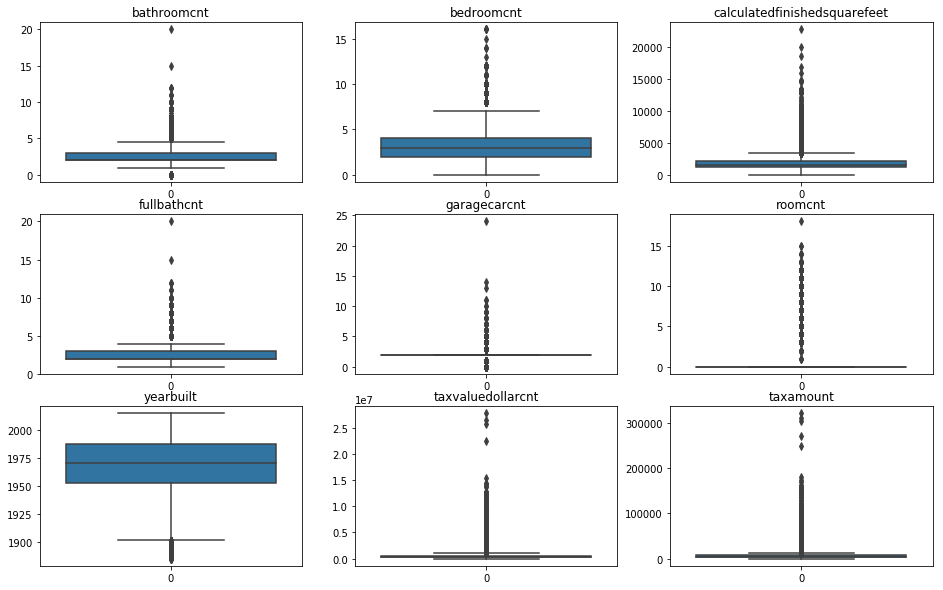

In [87]:
plt.figure(figsize=(16, 10))

for i, col in enumerate(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'garagecarcnt', 'roomcnt', 'yearbuilt', 'taxvaluedollarcnt', 'taxamount']):
    plot_number = i + 1
    series = df[col]
    plt.subplot(3, 3, plot_number)
    plt.title(col)
    sns.boxplot(data=series)
    

### Data Exploration

Goal is to address each of the questions you posed in your planning & brainstorming through visual or statistical analysis.

When you have completed this step, you will have the findings from your analysis that will be used in your final report, the answers to your questions and your customer's questions that will reach the goal. 

In [88]:
df2 = df2.drop(['parcelid', 'roomcnt', 'garagecarcnt', 'fullbathcnt'], axis=1) 

#creating column for new room count
df2 = df2.assign(rmcount=df2.bathroomcnt+df2.bedroomcnt)

#creating column for value per square foot
df2 = df2.assign(value_per_sq_ft=df2.taxvaluedollarcnt/df2.calculatedfinishedsquarefeet)
df2 = df2.drop(df2[(df2.value_per_sq_ft).isnull()].index)
df2 = df2.drop(df2[(df2.value_per_sq_ft > 7000)].index)
df2.sort_values(['value_per_sq_ft'], ascending=True)

#creating column for age of property
df2 = df2.drop(df2[(df2.yearbuilt).isnull()].index)
df2 = df2.assign(age_of_property=2016-df2.yearbuilt)
df2.describe()

# creating column for absolute value of log error
df2 = df2.assign(abs_logerror=df2.logerror.abs())

df2

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,yearbuilt,taxvaluedollarcnt,taxamount,rmcount,value_per_sq_ft,age_of_property,abs_logerror
0,0.0953,2.5,3.0,1264.0,1986.0,191811.0,2015.06,5.5,151.749209,30.0,0.0953
1,0.0198,1.0,2.0,777.0,1990.0,239679.0,2581.30,3.0,308.467181,26.0,0.0198
2,0.0060,2.0,3.0,1101.0,1956.0,47853.0,591.64,5.0,43.463215,60.0,0.0060
3,-0.0566,1.5,2.0,1554.0,1965.0,62914.0,682.78,3.5,40.485199,51.0,0.0566
4,0.0573,2.5,4.0,2415.0,1984.0,554000.0,5886.92,6.5,229.399586,32.0,0.0573
5,0.0564,2.5,4.0,2882.0,1980.0,289609.0,3110.44,6.5,100.488897,36.0,0.0564
6,0.0315,2.0,3.0,1772.0,1978.0,526000.0,5632.20,5.0,296.839729,38.0,0.0315
7,0.0257,2.5,5.0,2632.0,1971.0,571086.0,6109.94,7.5,216.977964,45.0,0.0257
8,0.0020,2.0,3.0,1292.0,1979.0,462594.0,5026.40,5.0,358.044892,37.0,0.0020
9,-0.0576,1.0,3.0,1385.0,1950.0,268502.0,3217.06,4.0,193.864260,66.0,0.0576


#### Split data into training and test datasets

In [89]:
X = df2.drop(['logerror', 'abs_logerror'], axis=1) #make sure to use capital X
y = df2[['logerror']] #y is dependent variable

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1) #axis = columns
test = pd.concat([X_test, y_test], axis=1)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


#### Create a jointplot for each independent variable with the dependent variable. 

Be sure you have Pearson's r and p-value annotated on each plot.

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWa

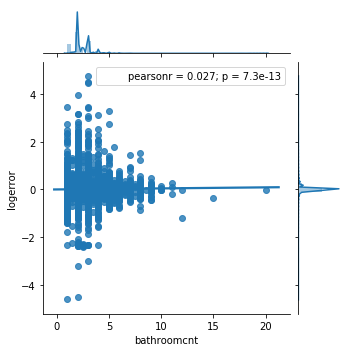

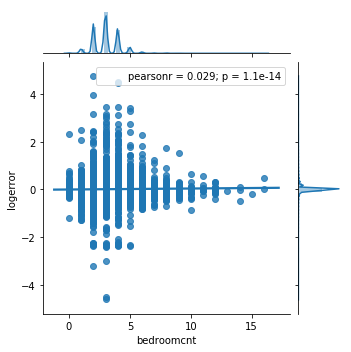

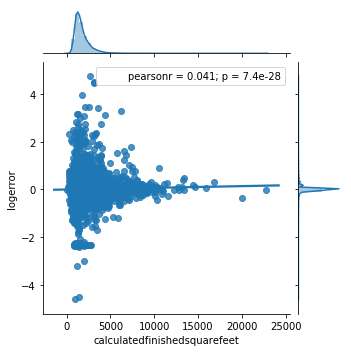

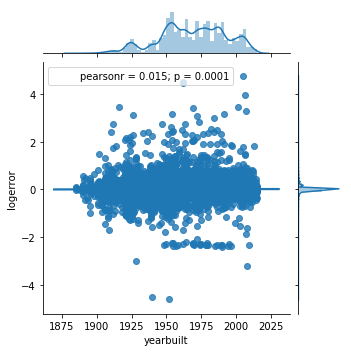

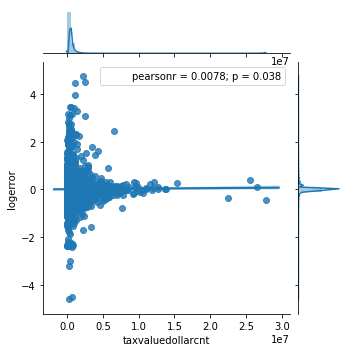

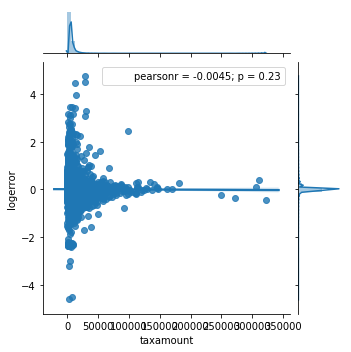

In [90]:
for i, col in enumerate(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'taxvaluedollarcnt', 'taxamount']):
    plot_number = i + 1 
    series = df[col]
    j = sns.jointplot(col, "logerror", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

#### Create a feature plot using seaborn's PairGrid() of the interaction between each variable (dependent + independent). 

You may want to use a normalized dataframe (if you did that) or adjust the axis scale (set to logarithmic, e.g) so you can more clearly view the interactions.

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


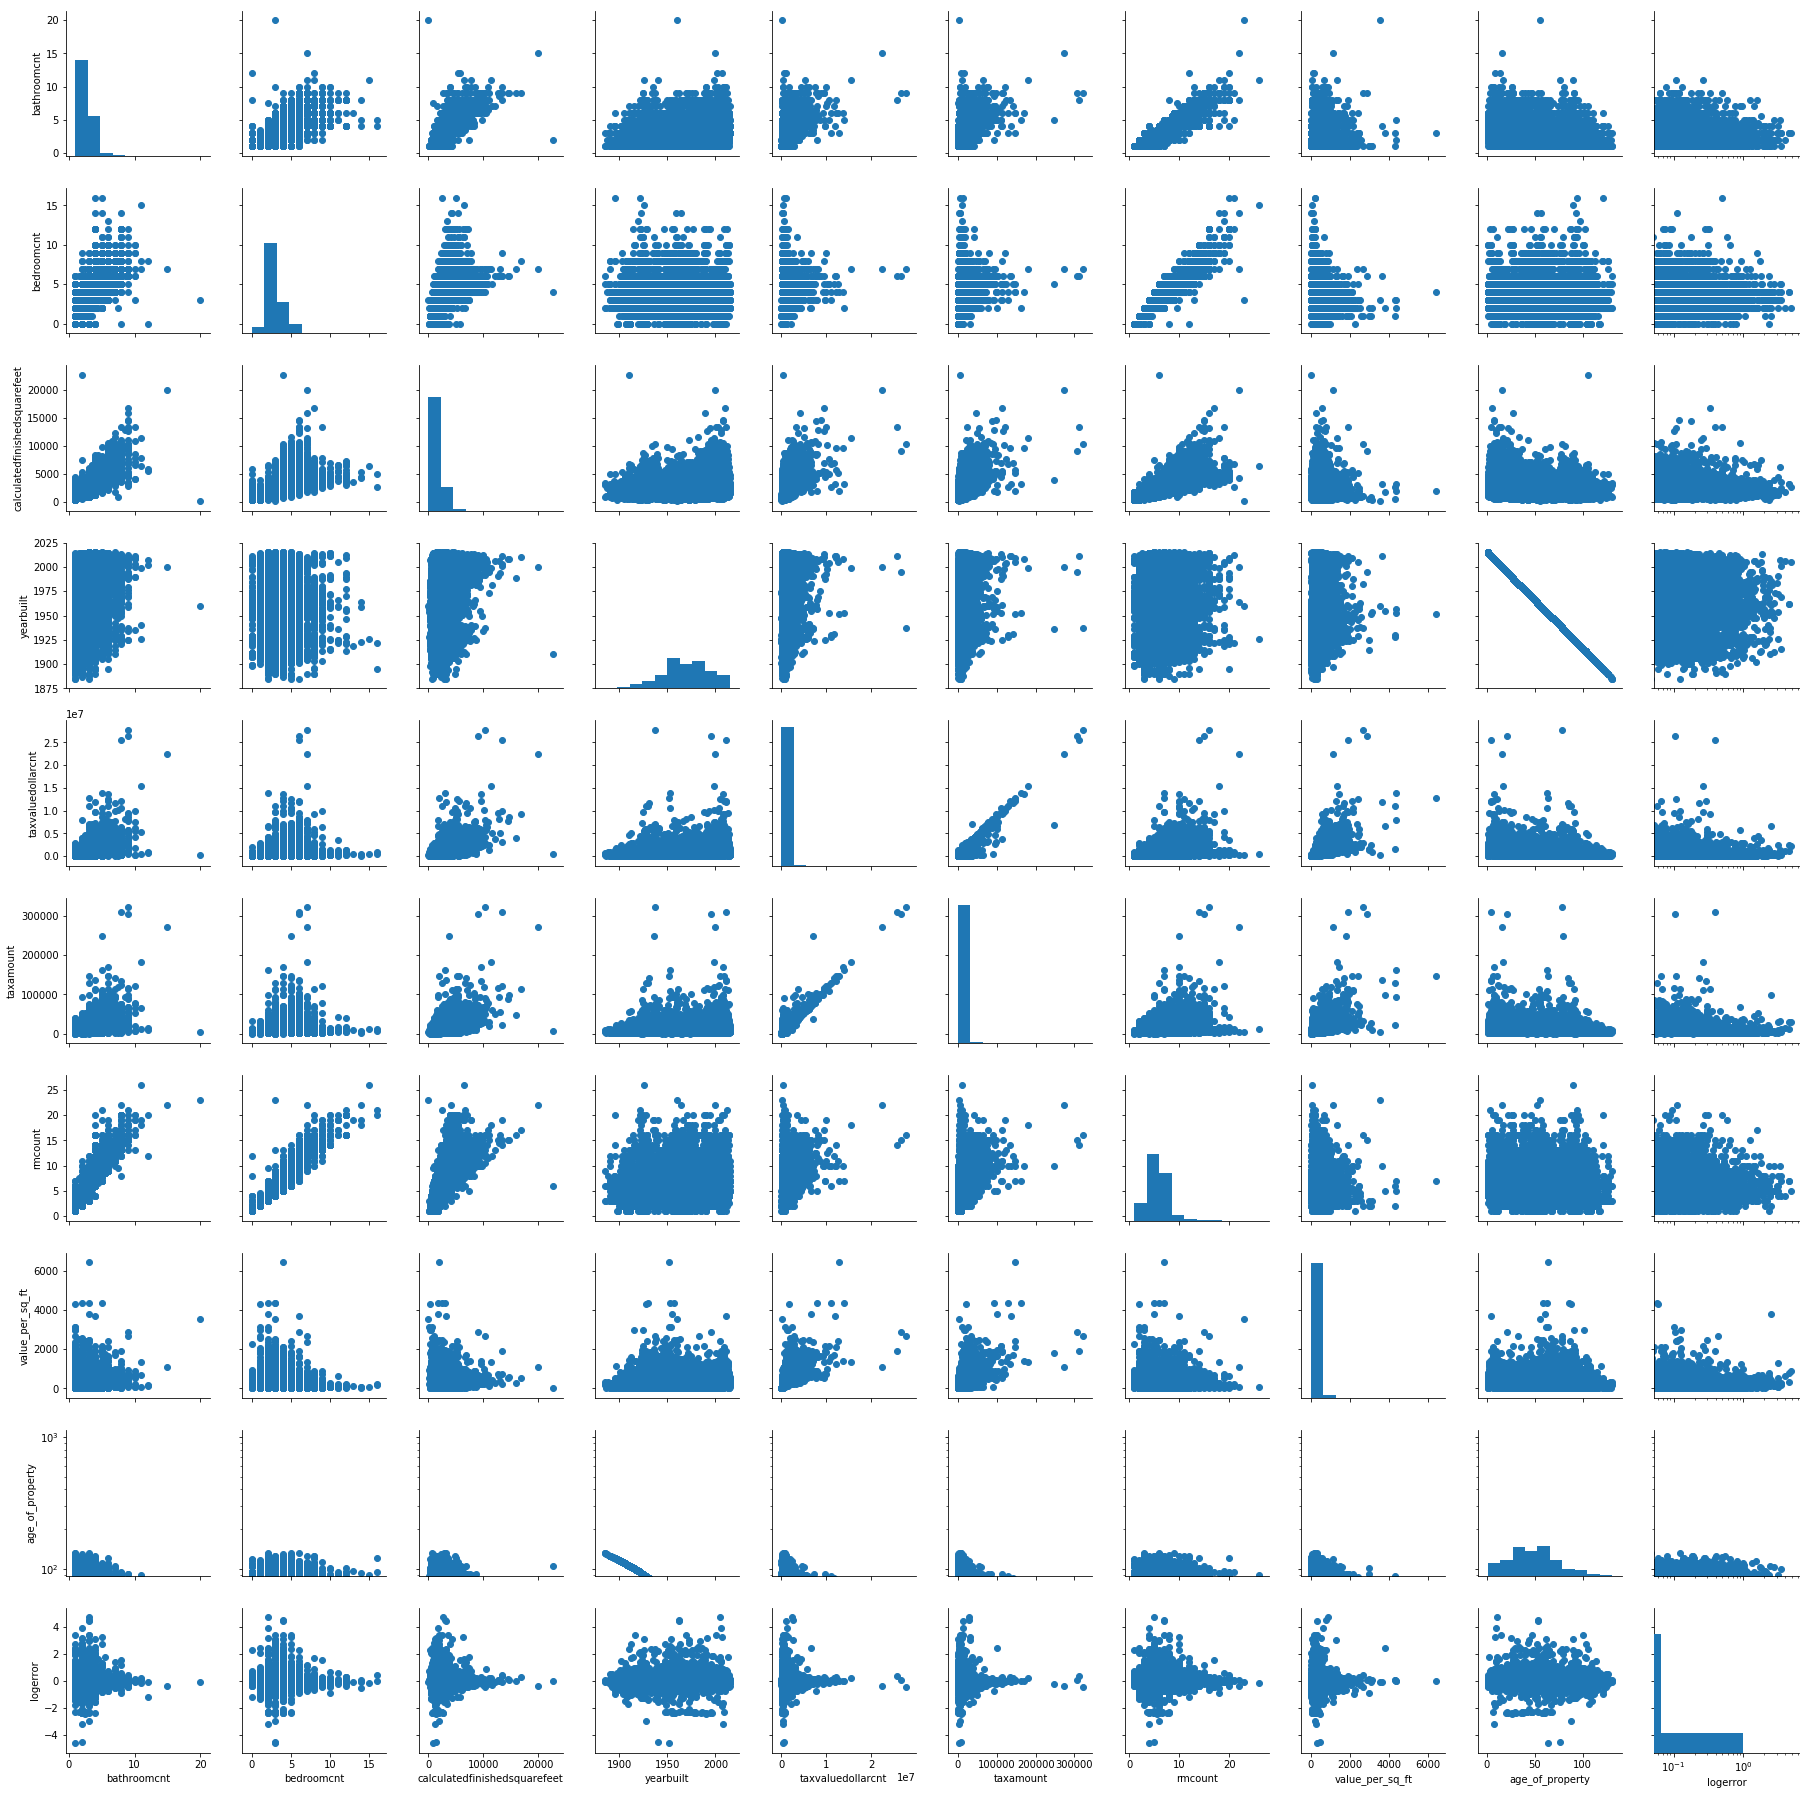

In [91]:
g = sns.PairGrid(train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
plt.xscale('log')
plt.yscale('log')
plt.show()

#### Create a heatmap of the correlation between each variable pair.

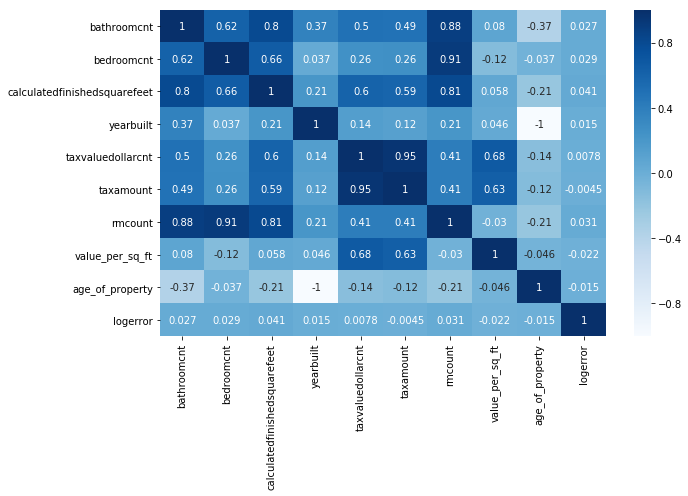

In [92]:
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(), cmap='Blues', annot=True)

#### Summarize your conclusions from all of these steps.  

- No single variable seems to have a strong correlation with log error 
- Groups of variables correlate with each other, such as calculatedfinishedsquarefeet with room count, tax amount with calculatedfinishedsquarefeet, and tax amount with taxvaluedollarcnt

#### Is the logerror significantly different for homes with 3 bedrooms vs those with 5 or more bedrooms? 
Run a t-test to test this difference.

In [93]:
train3 = train[train.bedroomcnt == 3]
train5 = train[train.bedroomcnt >= 5]

ttest_ind(train5.logerror, train3.logerror)

Ttest_indResult(statistic=5.536271182524083, pvalue=3.112757428300649e-08)

In [24]:
ols_model = sm.OLS(train3.logerror, train3.bedroomcnt)
fit = ols_model.fit()
fit.summary()

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1554: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           abs_logerror   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                      -inf
Date:                Sun, 24 Mar 2019   Prob (F-statistic):                nan
Time:                        11:24:09   Log-Likelihood:                 16314.
No. Observations:               28270   AIC:                        -3.263e+04
Df Residuals:                   28269   BIC:                        -3.262e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bedroomcnt     0.0210      0.000     78.009      0.000       0.020       0.022
==============================================================================
Omnibus:                    47402.927   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         56088687.883
Skew:                          11.343   Prob(JB):                         0.00
Kurtosis:                     220.030   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
ols_model = sm.OLS(train5.logerror, train5.bedroomcnt)
fit = ols_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logerror   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     85.92
Date:                Mon, 25 Mar 2019   Prob (F-statistic):           2.64e-20
Time:                        16:46:23   Log-Likelihood:                 1473.1
No. Observations:                5468   AIC:                            -2944.
Df Residuals:                    5467   BIC:                            -2937.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bedroomcnt     0.0042      0.000      9.269      0.000       0.003       0.005
==============================================================================
Omnibus:                     5233.174   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1478381.769
Skew:                           3.950   Prob(JB):                         0.00
Kurtosis:                      83.165   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Do the same for another 2 samples you are interested in comparing (e.g. those with 1 bath vs. x baths)

In [95]:
train_bath1 = train[train.bathroomcnt <= 3]
train_bath2 = train[train.bathroomcnt >= 4]

ttest_ind(train_bath1.logerror, train_bath2.logerror)

Ttest_indResult(statistic=-6.016379566395594, pvalue=1.7923990095350131e-09)

In [96]:
ols_model = sm.OLS(train_bath1.logerror, train_bath1.bathroomcnt)
fit = ols_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logerror   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     309.0
Date:                Mon, 25 Mar 2019   Prob (F-statistic):           5.16e-69
Time:                        16:46:47   Log-Likelihood:                 29269.
No. Observations:               64890   AIC:                        -5.854e+04
Df Residuals:                   64889   BIC:                        -5.853e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
bathroomcnt     0.0048      0.000     17.579      0.000       0.004       0.005
==============================================================================
Omnibus:                    50221.662   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         64815080.036
Skew:                           2.348   Prob(JB):                         0.00
Kurtosis:                     157.759   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
ols_model = sm.OLS(train_bath2.logerror, train_bath2.bathroomcnt)
fit = ols_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logerror   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     77.11
Date:                Mon, 25 Mar 2019   Prob (F-statistic):           2.14e-18
Time:                        16:46:54   Log-Likelihood:                 1043.9
No. Observations:                5371   AIC:                            -2086.
Df Residuals:                    5370   BIC:                            -2079.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
bathroomcnt     0.0050      0.001      8.781      0.000       0.004       0.006
==============================================================================
Omnibus:                     4616.588   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           785499.213
Skew:                           3.410   Prob(JB):                         0.00
Kurtosis:                      61.851   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## train ols room count

In [98]:
ols_model = sm.OLS(train.logerror, train.rmcount)
fit = ols_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logerror   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     448.9
Date:                Mon, 25 Mar 2019   Prob (F-statistic):           2.57e-99
Time:                        16:47:03   Log-Likelihood:                 30472.
No. Observations:               71118   AIC:                        -6.094e+04
Df Residuals:                   71117   BIC:                        -6.093e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
rmcount        0.0022      0.000     21.187      0.000       0.002       0.002
==============================================================================
Omnibus:                    56622.585   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         58693900.139
Skew:                           2.534   Prob(JB):                         0.00
Kurtosis:                     143.647   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## train ols value per square foot

In [99]:
ols_model = sm.OLS(train.logerror, train.value_per_sq_ft)
fit = ols_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logerror   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     155.8
Date:                Mon, 25 Mar 2019   Prob (F-statistic):           1.00e-35
Time:                        16:47:22   Log-Likelihood:                 30326.
No. Observations:               71118   AIC:                        -6.065e+04
Df Residuals:                   71117   BIC:                        -6.064e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
value_per_sq_ft  2.383e-05   1.91e-06     12.484      0.000    2.01e-05    2.76e-05
==============================================================================
Omnibus:                    56337.632   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         57846355.402
Skew:                           2.512   Prob(JB):                         0.00
Kurtosis:                     142.628   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## train ols age of property

In [100]:
ols_model = sm.OLS(train.logerror, train.age_of_property)
fit = ols_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logerror   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     246.7
Date:                Mon, 25 Mar 2019   Prob (F-statistic):           1.72e-55
Time:                        16:47:32   Log-Likelihood:                 30372.
No. Observations:               71118   AIC:                        -6.074e+04
Df Residuals:                   71117   BIC:                        -6.073e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
age_of_property     0.0002   1.12e-05     15.705      0.000       0.000       0.000
==============================================================================
Omnibus:                    56257.331   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         58299862.721
Skew:                           2.502   Prob(JB):                         0.00
Kurtosis:                     143.176   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Data Modeling

#### Feature Engineering & Selection

#### Are there new features you could create based on existing features that might be helpful? 
Created a new room count column that is the sum of bathroom count and bedroom count, after removing the column for full bath and removing bathroom counts that were zero. Also created a column for value per sq ft, age of property, and absolute value of log error. 

#### Summarize your conclusions and next steps from your analysis in above. 
What will you try when developing your model? (which features to use/not use/etc)

- new room count
- value per sq ft
- age of property
- age of property with taxvaluedollarcnt
- age of property with taxvaluedollarcnt with new room count
- will not use absolute value of log error

#### Train & Test Model

#### Fit, predict (in-sample) & evaluate multiple linear regression models to find the best one.

## LM1 - Room count

In [101]:
lm1 = LinearRegression() 
print(lm1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [102]:
lm1.fit(X_train[['rmcount']], y_train)
print(lm1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [103]:
#parameters
lm1_y_intercept = lm1.intercept_
print(lm1_y_intercept)

lm1_coefficients = lm1.coef_
print(lm1_coefficients)

[-0.00254529]
[[0.00262152]]


## Predict

In [104]:
y_pred_lm1 = lm1.predict(X_train[['rmcount']])
print(y_pred_lm1)

[[0.00925157]
 [0.00794081]
 [0.01056233]
 ...
 [0.01056233]
 [0.00531928]
 [0.01056233]]


## Evaluate

In [105]:
mse_lm1 = mean_squared_error(y_train, y_pred_lm1)
print("lm1\n  mse: {:.3}".format(mse_lm1)) 

lm1
  mse: 0.0249


In [106]:
r2_lm1 = r2_score(y_train, y_pred_lm1)
print('R squared value for lm1: {:.2%}'.format(r2_lm1))

R squared value for lm1: 0.10%


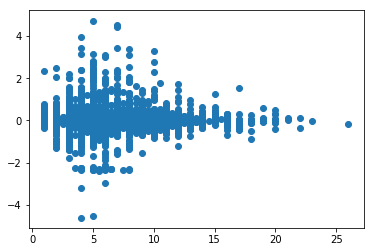

In [107]:
plt.scatter(X_train[['rmcount']], y_train)

## LM2- Tax amount

In [108]:
lm2 = LinearRegression() 
print(lm2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [109]:
lm2.fit(X_train[['value_per_sq_ft']], y_train)
print(lm1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [110]:
#parameters
lm2_y_intercept = lm2.intercept_
print(lm2_y_intercept)

lm2_coefficients = lm2.coef_
print(lm2_coefficients)

[0.01645496]
[[-1.9389805e-05]]


## Predict

In [111]:
y_pred_lm2 = lm2.predict(X_train[['value_per_sq_ft']])
print(y_pred_lm2)

[[0.0088123 ]
 [0.0124881 ]
 [0.01179504]
 ...
 [0.01354914]
 [0.01569978]
 [0.01272278]]


## Evaluate

In [112]:
mse_lm2 = mean_squared_error(y_train, y_pred_lm2)
print("lm2\n  mse: {:.3}".format(mse_lm1)) 

lm2
  mse: 0.0249


In [113]:
r2_lm2 = r2_score(y_train, y_pred_lm2)
print('R squared value for lm2: {:.2%}'.format(r2_lm2))

R squared value for lm2: 0.05%


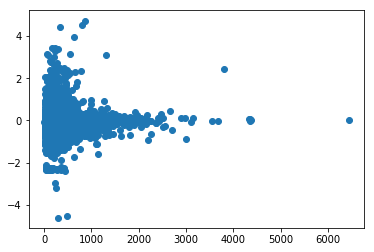

In [114]:
plt.scatter(X_train[['value_per_sq_ft']], y_train)

## LM3- Age of property

In [115]:
lm3 = LinearRegression() 
print(lm3)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [116]:
lm3.fit(X_train[['age_of_property']], y_train)
print(lm3)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [117]:
#parameters
lm3_y_intercept = lm3.intercept_
print(lm3_y_intercept)

lm3_coefficients = lm3.coef_
print(lm3_coefficients)

[0.01613522]
[[-9.66637577e-05]]


## Predict

In [118]:
y_pred_lm3 = lm3.predict(X_train[['age_of_property']])
print(y_pred_lm3)

[[0.0132353 ]
 [0.01333197]
 [0.01130203]
 ...
 [0.01246199]
 [0.00975541]
 [0.01188201]]


## Evaluate

In [119]:
mse_lm3 = mean_squared_error(y_train, y_pred_lm3)
print("lm3\n  mse: {:.3}".format(mse_lm3)) 

lm3
  mse: 0.0249


In [120]:
r2_lm3 = r2_score(y_train, y_pred_lm3)
print('R squared value for lm3: {:.2%}'.format(r2_lm3))

R squared value for lm3: 0.02%


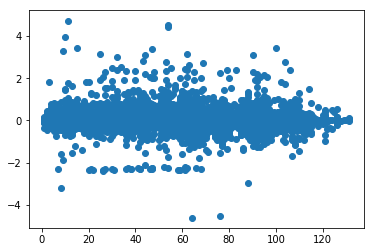

In [121]:
plt.scatter(X_train[['age_of_property']], y_train)

## LM4- Age of property, tax value dollar amount

In [122]:
lm4 = LinearRegression() 
print(lm4)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [123]:
lm4.fit(X_train[['age_of_property', 'taxvaluedollarcnt']], y_train)
print(lm4)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [124]:
#parameters
lm4_y_intercept = lm4.intercept_
print(lm4_y_intercept)

lm4_coefficients = lm4.coef_
print(lm4_coefficients)

[0.01510655]
[[-9.11574092e-05  1.68260812e-09]]


## Predict

In [125]:
y_pred_lm4 = lm4.predict(X_train[['age_of_property', 'taxvaluedollarcnt']])
print(y_pred_lm4)

[[0.01403981]
 [0.01280378]
 [0.01123855]
 ...
 [0.01227953]
 [0.00917693]
 [0.01148848]]


## Evaluate

In [126]:
mse_lm4 = mean_squared_error(y_train, y_pred_lm4)
print("lm4\n  mse: {:.3}".format(mse_lm4)) 

lm4
  mse: 0.0249


In [127]:
r2_lm4 = r2_score(y_train, y_pred_lm4)
print('R squared value for lm4: {:.2%}'.format(r2_lm4))

R squared value for lm4: 0.02%


## LM5- Age of property, taxvaluedollarcnt, rmcount

In [128]:
lm5 = LinearRegression() 
print(lm5)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [129]:
lm5.fit(X_train[['age_of_property', 'taxvaluedollarcnt', 'rmcount']], y_train)
print(lm5)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [130]:
#parameters
lm5_y_intercept = lm5.intercept_
print(lm5_y_intercept)

lm5_coefficients = lm5.coef_
print(lm5_coefficients)

[0.00066499]
[[-5.74226585e-05 -1.89249231e-09  2.69135827e-03]]


## Predict

In [131]:
y_pred_lm5 = lm5.predict(X_train[['age_of_property', 'taxvaluedollarcnt', 'rmcount']])
print(y_pred_lm5)

[[0.00917738]
 [0.00938186]
 [0.01047472]
 ...
 [0.01122331]
 [0.00485158]
 [0.01115332]]


## Evaluate

In [132]:
mse_lm5 = mean_squared_error(y_train, y_pred_lm5)
print("lm5\n  mse: {:.3}".format(mse_lm5)) 

lm5
  mse: 0.0248


In [133]:
r2_lm5 = r2_score(y_train, y_pred_lm5)
print('R squared value for lm5: {:.2%}'.format(r2_lm5))

R squared value for lm5: 0.11%


Highest R squared value was with model LM5 at 0.11%, so I will use this model on the test data. 

## Out-of-sample data (Test) - age/tax value

In [134]:
y_pred_lm5 = lm5.predict(X_test[['age_of_property', 'taxvaluedollarcnt', 'rmcount']])

In [135]:
mse = mean_squared_error(y_test, y_pred_lm5)

print("Mean squared error: %.2f" % mse)

Mean squared error: 0.03


In [136]:
r2 = r2_score(y_test, y_pred_lm5)

print('{:.2%} of the variance in absolute log error can be explained by age of property, tax value dollar count, and room count.'
      .format(r2))

0.15% of the variance in absolute log error can be explained by age of property, tax value dollar count, and room count.


Text(0.5, 1.0, 'Predicted vs Actual Log Error for test sample')

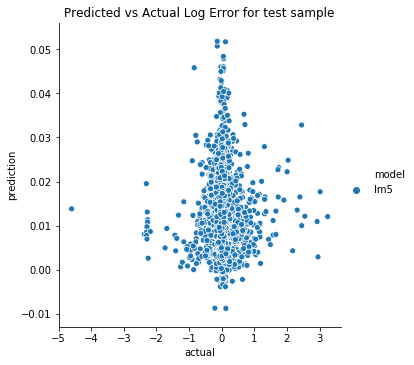

In [138]:
pd.DataFrame({'actual': y_test.logerror,
              'lm5': y_pred_lm5.ravel()})\
    .melt(id_vars=['actual'], var_name='model', value_name='prediction')\
    .pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')

plt.title('Predicted vs Actual Log Error for test sample')

Text(0, 0.5, 'Residuals')

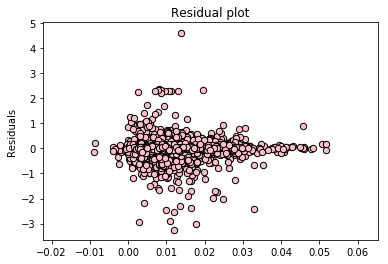

In [139]:
plt.scatter(y_pred_lm5, y_pred_lm5 - y_test, c='pink', s=40, edgecolors='black')
plt.title("Residual plot")
plt.ylabel('Residuals')

### Summarize your expectations about how you estimate this model will perform in production.

- This model will not significantly change the current Zestimate error.
- More work needs to be done to come to any solid conclusions.
- Binning the data might uncover where the errors lie
- Based on the residual plot, there is a pattern of the residuals grouping in one area, and therefore there is some more work to be done.
- Not one feature alone drives error, but all features are important and would need more exploring.